In [1]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.ndimage as ndi

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from tqdm.auto import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

np.random.seed(0)
sns.set_style("whitegrid")

In [2]:
DATASET_PATH = os.getenv('DATASET_PATH')
PATH_TO_LEARNED_MODEL = os.getenv('PATH_TO_LEARNED_MODEL')
FORCE_TRAIN = False 

In [3]:
files = os.listdir(DATASET_PATH)

patient_id_list = []
patient_label_list = []
patient_label_image_path_list = []

for file in tqdm(files):
    if file != '.DS_Store':
        patient_id = file
        patient_data_path = DATASET_PATH + patient_id + "/"
        patient_labels = os.listdir(patient_data_path)
        for patient_label in patient_labels:
            if patient_label != '.DS_Store':
                patient_labels_path = patient_data_path + patient_label + "/"
                patient_label_images = os.listdir(patient_labels_path)
                for patient_label_image in patient_label_images:
                    if patient_label_image != '.DS_Store':
                        patient_label_image_path = patient_labels_path + patient_label_image
                        patient_id_list.append(int(patient_id))
                        patient_label_list.append(int(patient_label))
                        patient_label_image_path_list.append(patient_label_image_path)

patients_df = pd.DataFrame(
    {'patient_id': patient_id_list,
     'label': patient_label_list,
     'image_path': patient_label_image_path_list
    })

patients_df.head()

  0%|          | 0/280 [00:00<?, ?it/s]

patient_id  label                                         image_path
0        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
1        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
2        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
3        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
4        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...

In [4]:
patients_df['patient_id'].value_counts()

patient_id
13693    2395
16550    2302
10288    2278
10308    2278
9323     2216
         ... 
16895     151
9175      118
8957      111
9262       94
16534      63
Name: count, Length: 279, dtype: int64

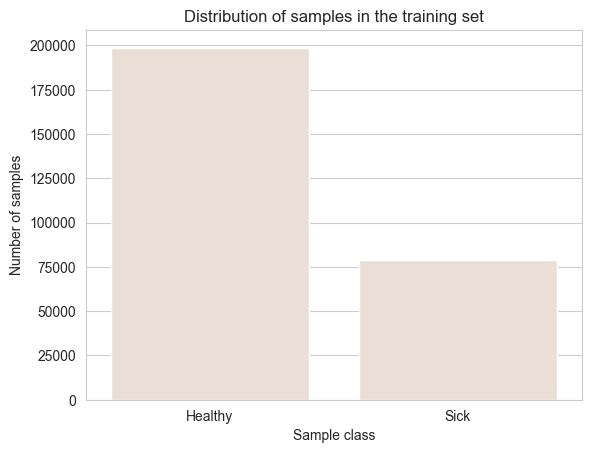

In [5]:
sns.countplot(x = patients_df['label'].map({0:"healthy", 1:"sick"}), order=["healthy","sick"], color=(0.929, 0.867, 0.831))
plt.title("Distribution of samples in the training set")
plt.xlabel("Sample class")
plt.ylabel("Number of samples")
ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_xticklabels(["Healthy", "Sick"])
plt.show()

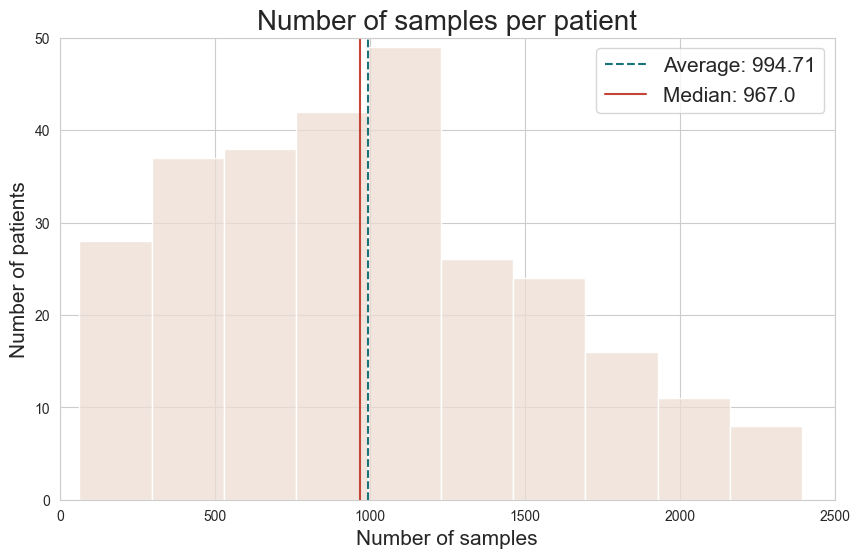

In [6]:
patches_per_patient = patients_df['patient_id'].value_counts()
mean = patches_per_patient.mean()
median = patches_per_patient.median()

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(patches_per_patient, bins = 10, color = (0.929, 0.867, 0.831))
plt.title("Number of samples per patient", fontsize = 20)
plt.axvline(mean, color=(0.098, 0.447, 0.471), linestyle='--')
plt.axvline(median, color=(0.769, 0.271, 0.212), linestyle='-')
plt.xlabel("Number of samples", fontsize = 15)
plt.ylabel("Number of patients", fontsize = 15)
plt.ylim(0, 50)
plt.xlim(0,2500)
plt.legend({'Average: ' + str(round(mean, 2)):mean,'Median: ' + str(round(median, 2)):median}, prop={'size': 15})
plt.show()

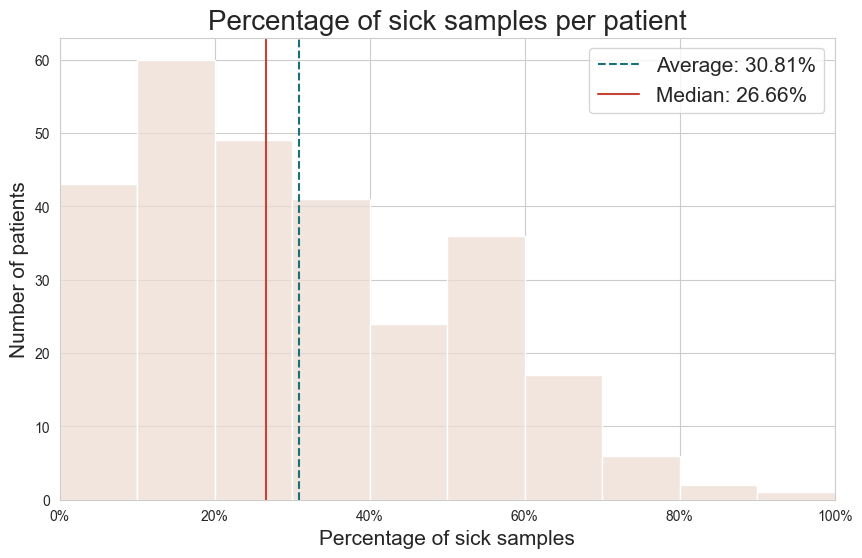

In [83]:
positive_patches_percentage = patients_df['patient_id'][patients_df['label'] == 1].value_counts() / patients_df['patient_id'].value_counts() * 100
mean = positive_patches_percentage.mean()
median = positive_patches_percentage.median()

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(positive_patches_percentage, bins = range(0, 110, 10), color = (0.929, 0.867, 0.831))
plt.title("Percentage of sick samples per patient", fontsize = 20)
plt.axvline(mean, color=(0.098, 0.447, 0.471), linestyle='--')
plt.axvline(median, color=(0.769, 0.271, 0.212), linestyle='-')
plt.xlabel("Percentage of sick samples", fontsize = 15)
plt.ylabel("Number of patients", fontsize = 15)
plt.gca().xaxis.set_major_formatter(PercentFormatter())
plt.xlim(0,100)
plt.legend({'Average: ' + str(round(mean, 2)) + '%':mean,'Median: ' + str(round(median, 2)) + '%':median}, prop={'size': 15})
plt.show()

In [8]:
positive_cases = np.random.choice(patients_df[patients_df['label'] == 1].index.values, size=36, replace=False)
negative_cases = np.random.choice(patients_df[patients_df['label'] == 0].index.values, size=36, replace=False)

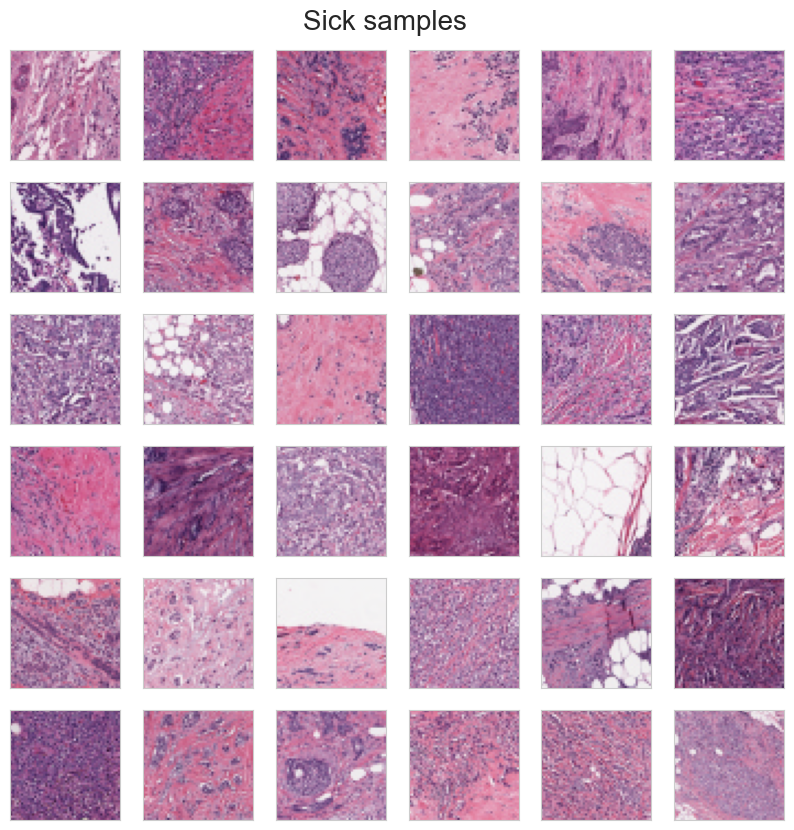

In [9]:
fig, ax = plt.subplots(6,6,figsize=(10, 10))
fig.suptitle('Sick samples', y = 0.92, fontsize = 20)
for x in range(6):
    for y in range(6):
        xy = positive_cases[x + y * 6]
        image = plt.imread(patients_df.loc[xy, "image_path"])
        ax[x,y].imshow(image)
        ax[x,y].grid(False)
        ax[x,y].set_xticks([])
        ax[x,y].set_yticks([])

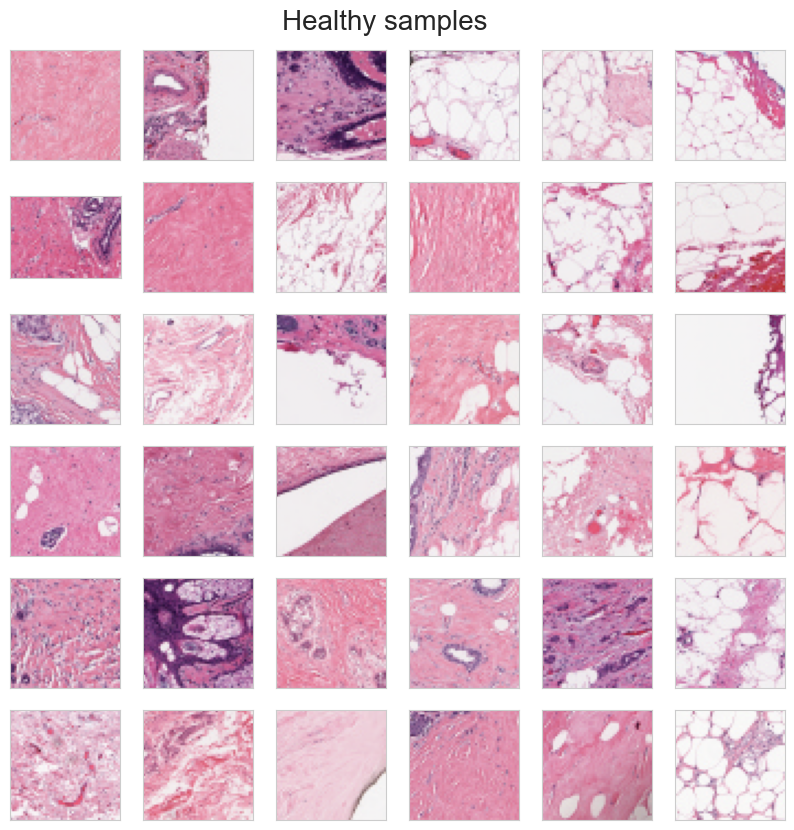

In [10]:
fig, ax = plt.subplots(6,6,figsize=(10, 10))
fig.suptitle('Healthy samples', y = 0.92, fontsize = 20)
for x in range(6):
    for y in range(6):
        xy = negative_cases[x + y * 6]
        image = plt.imread(patients_df.loc[xy, "image_path"])
        ax[x,y].imshow(image)
        ax[x,y].grid(False)
        ax[x,y].set_xticks([])
        ax[x,y].set_yticks([])

In [11]:
def plotHistogram(image_path):
    image = plt.imread(image_path)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Number of pixels')
    histo.set_xlabel('Pixel intensity')
    n_bins = 30
    image = image * 256
    sns.histplot(image[:,:,0].flatten(), bins= n_bins, lw = 0, color=(0.94, 0.28, 0.44), alpha=0.7);
    sns.histplot(image[:,:,1].flatten(), bins= n_bins, lw = 0, color=(0.2, 0.84, 0.63), alpha=0.7);
    sns.histplot(image[:,:,2].flatten(), bins= n_bins, lw = 0, color=(0.08, 0.74, 0.96), alpha=0.7);
    red_patch = mpatches.Patch(color= (0.94, 0.28, 0.44, 0.7), label='red')
    green_patch = mpatches.Patch(color= (0.2, 0.84, 0.63, 0.7), label='green')
    blue_patch = mpatches.Patch(color= (0.08, 0.74, 0.96, 0.7), label='blue')
    plt.legend(handles=[red_patch, green_patch, blue_patch], title="Channel:")

In [12]:
def extracting_coordinates(dataframe, patient_id=None):
    if patient_id != None:
        dataframe = dataframe[dataframe['patient_id'] == patient_id]
        
    coordinates = dataframe['image_path'].str.split("_", n=9, expand=True)
    coordinates = coordinates.drop([0, 1, 2, 3, 4, 5, 8], axis = 1)
    coordinates = coordinates.rename(columns={6: 'x', 7: 'y'})
    coordinates['x'] = coordinates['x'].str.replace('x', '').astype(int)
    coordinates['y'] = coordinates['y'].str.replace('y', '').astype(int)
    dataframe_coordinates_dict = {'patient_id': dataframe['patient_id'], 'x': coordinates['x'],'y': coordinates['y'],'label': dataframe['label'],'image_path': dataframe['image_path']}
    dataframe_coordinates = pd.DataFrame(dataframe_coordinates_dict)
    dataframe_coordinates.reset_index(drop=True, inplace=True)
    
    return dataframe_coordinates

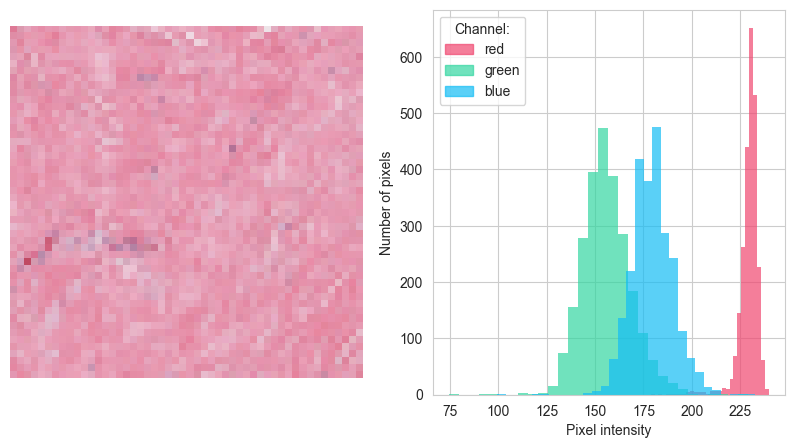

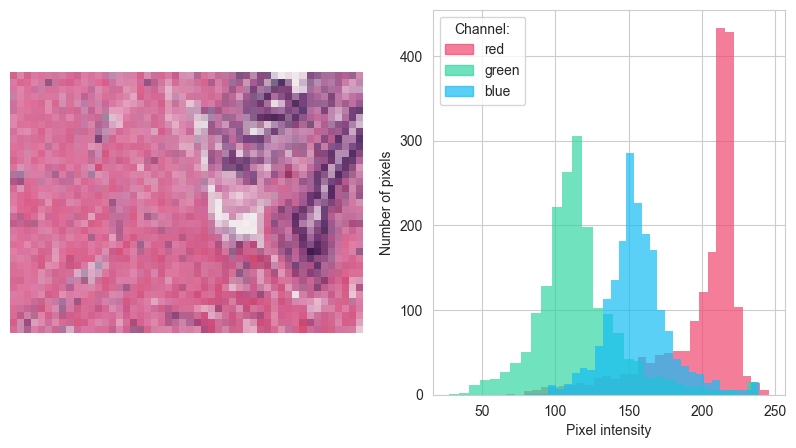

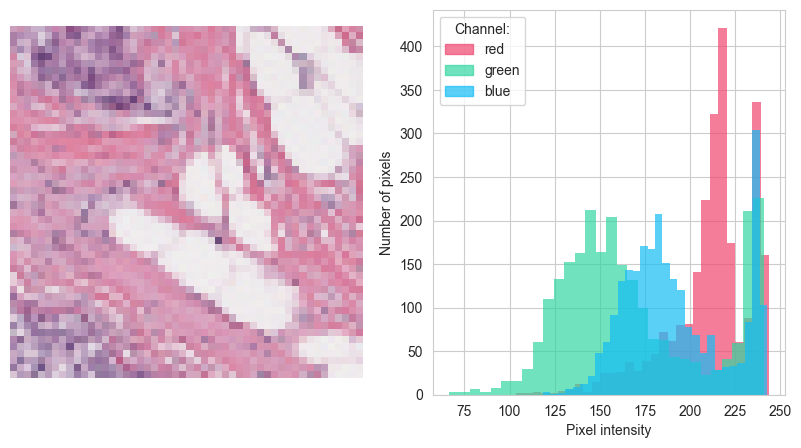

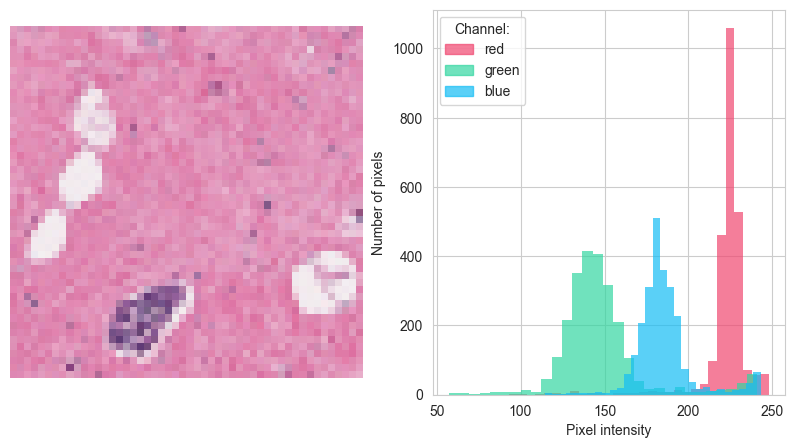

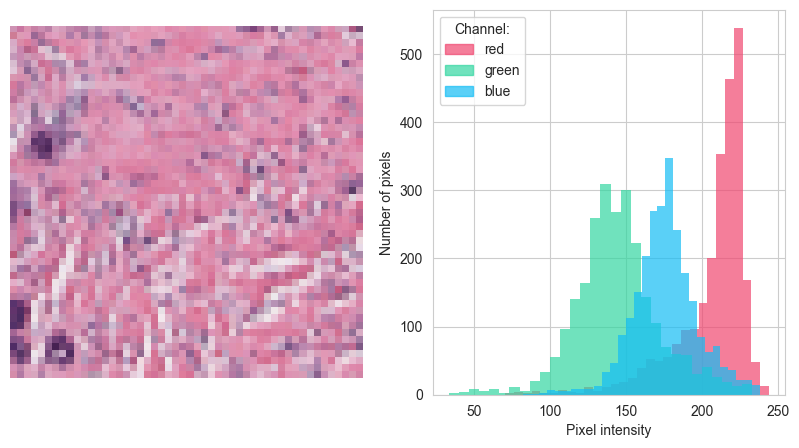

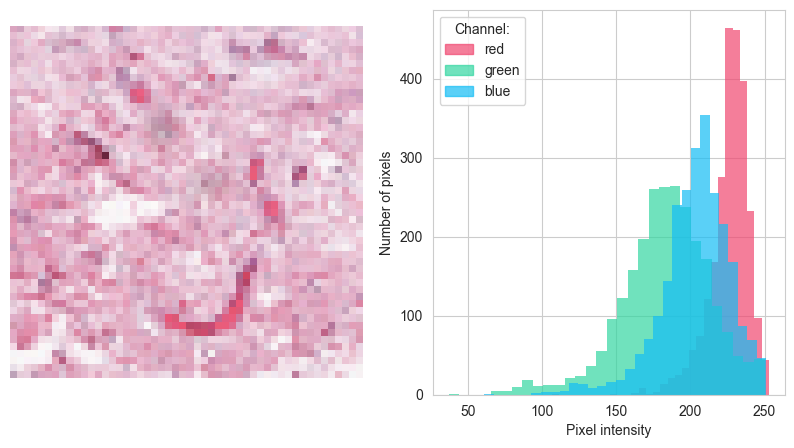

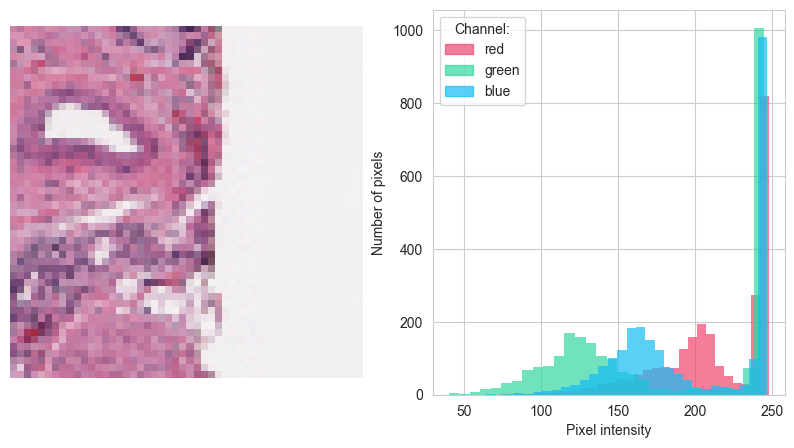

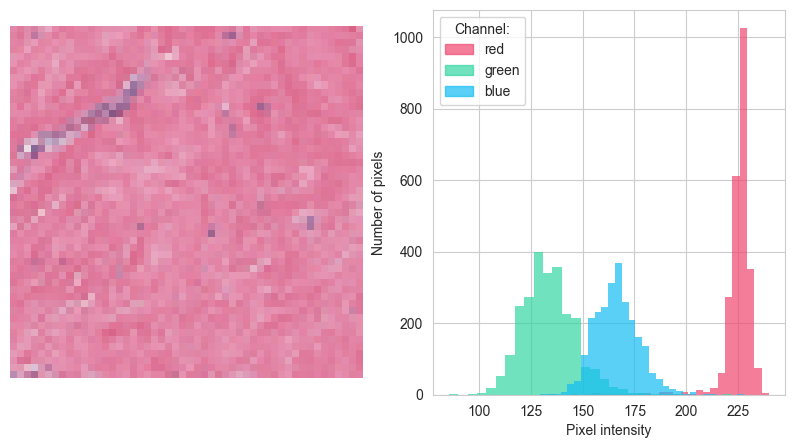

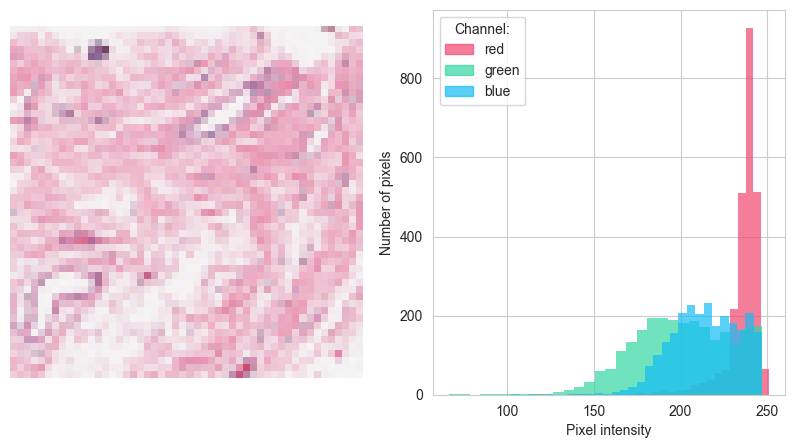

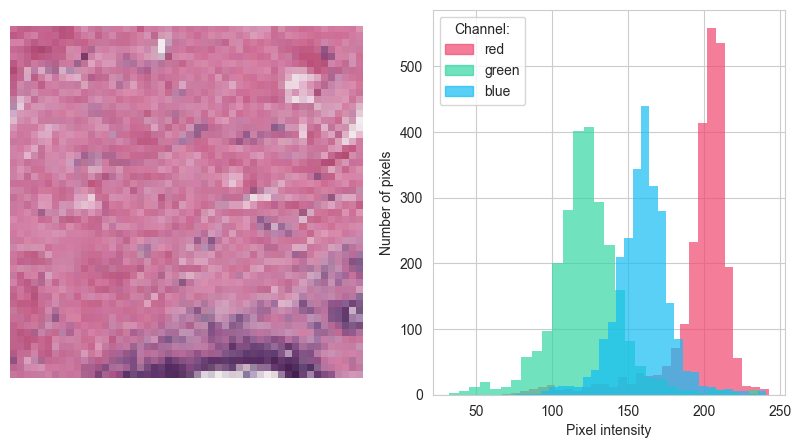

In [13]:
for i in range(10):
    plotHistogram(patients_df.loc[negative_cases[i], "image_path"])

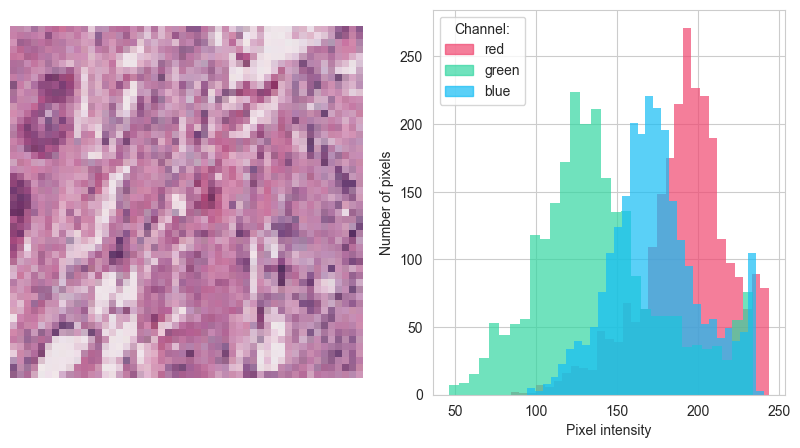

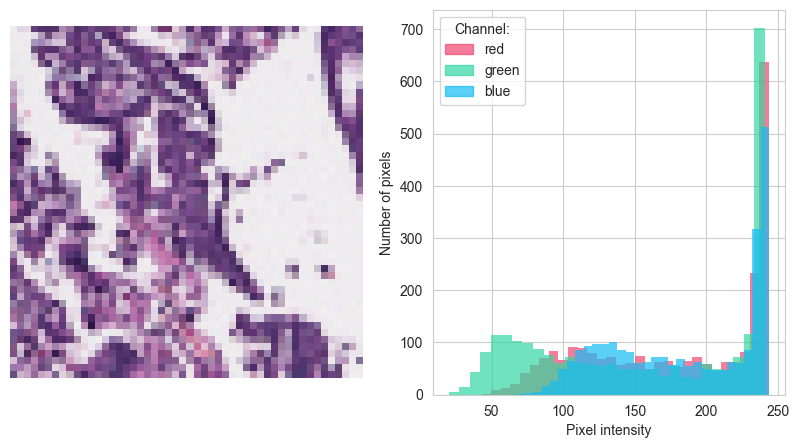

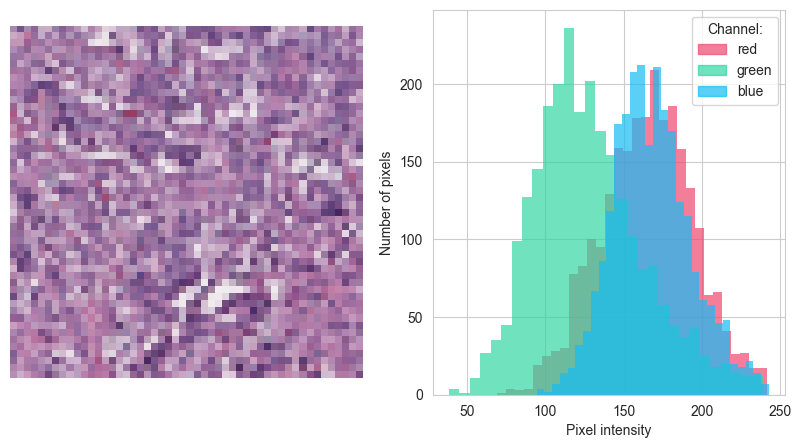

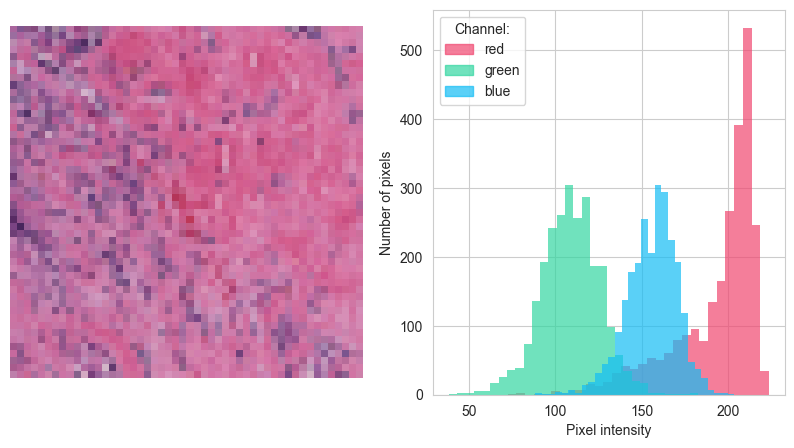

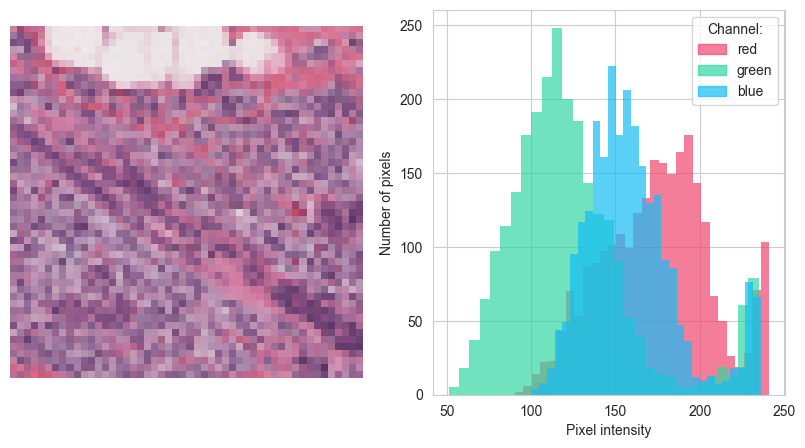

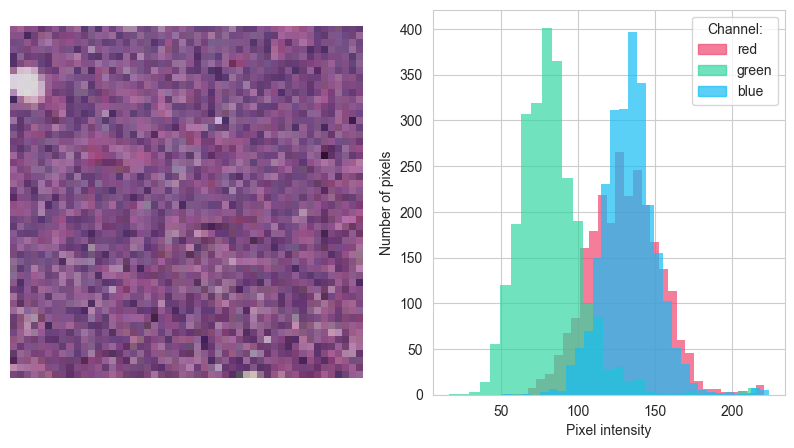

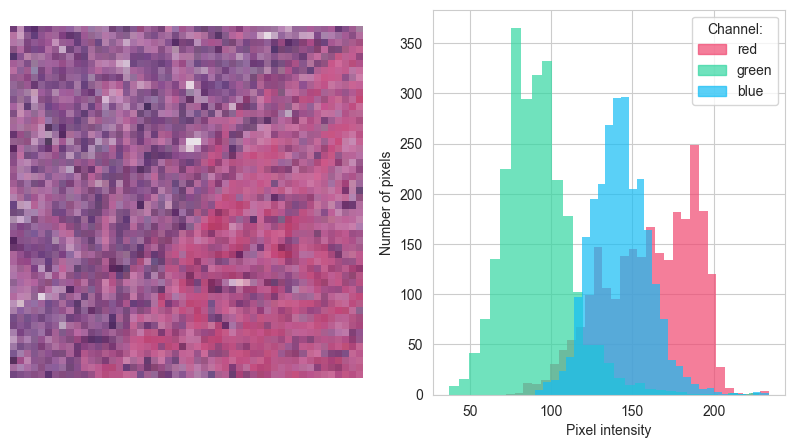

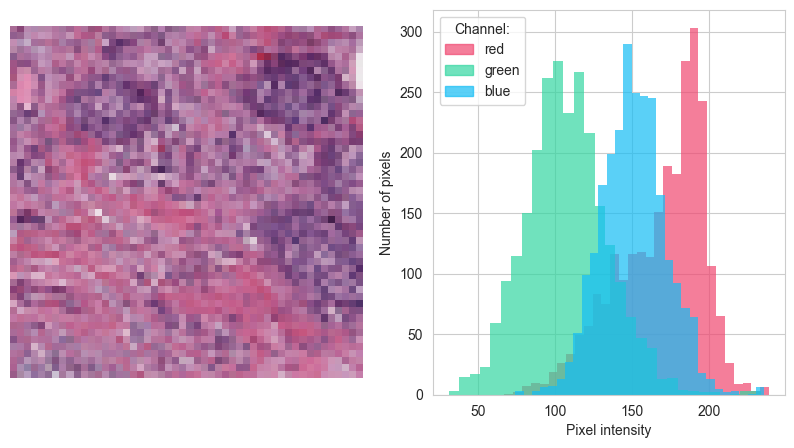

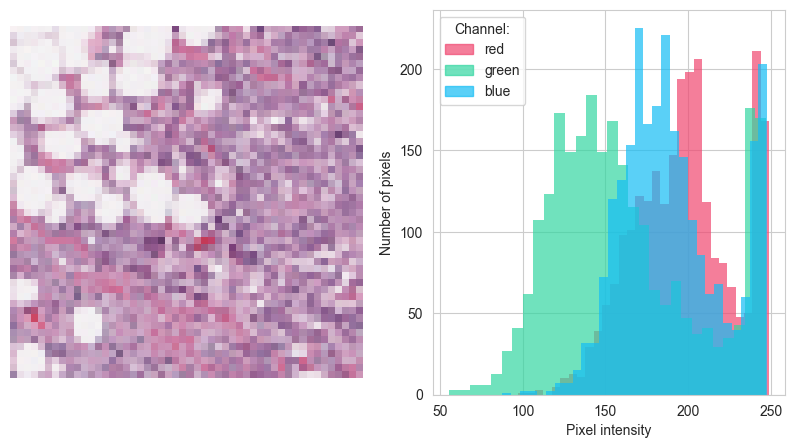

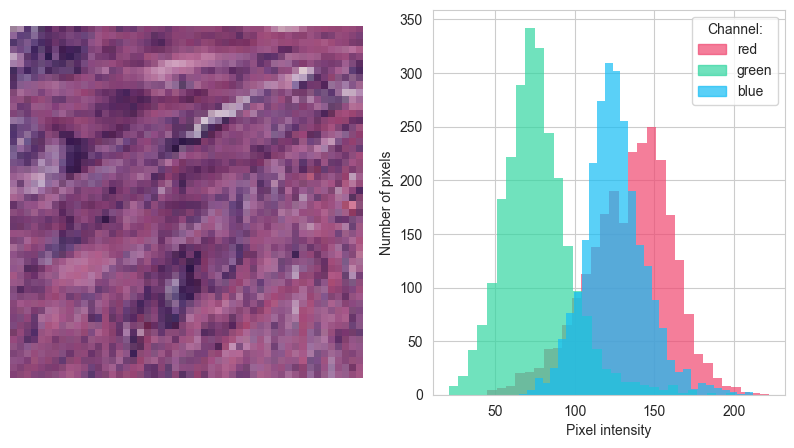

In [14]:
for i in range(10):
    plotHistogram(patients_df.loc[positive_cases[i], "image_path"])

In [15]:
def patient_samples_visualisation(patient_id, fig_x, fig_y):
    patient_df = extracting_coordinates(patients_df, patient_id)
    ax[fig_x,fig_y].set_title('Patient number ' + str(patient_id), fontsize = 15)
    sns.scatterplot(data = patient_df, x = 'x', y = 'y',s = 20, hue = 'label', palette = 'coolwarm', linewidth=0, ax = ax[fig_x,fig_y])
    ax[fig_x,fig_y].set_xlabel('X coordinate')
    ax[fig_x,fig_y].set_ylabel('Y coordinate')
    h, l = ax[fig_x,fig_y].get_legend_handles_labels()
    ax[fig_x,fig_y].legend(h, ['healthy', 'sick'], title='Sample type:')

In [16]:
def patient_tissue_visualisation(patient_id):
    df = extracting_coordinates(patients_df, patient_id)
    grid = 255*np.ones(shape = (max(df['y']) + 50 - 1, max(df['x']) + 50 - 1, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max(df['y']) + 50 - 1, max(df['x']) + 50 - 1, 3)).astype(np.uint8)
    
    for n in range(len(df)):
        image = plt.imread(df.loc[n,'image_path'])
        rgb_image = 255 * image
        x_start = df.loc[n,'x'] - 1
        y_start = df.loc[n,'y'] - 1
        x_end = x_start + image.shape[1]
        y_end = y_start + image.shape[0]
        grid[y_start:y_end,x_start:x_end] = rgb_image
            
        if (df.loc[n,'label'] == 1):
            mask[y_start:y_end,x_start:x_end] = (255, 0, 100)
            
    return grid, mask

In [78]:
random_patients = [14211, 9250, 10260, 14155, 13613, 12880]

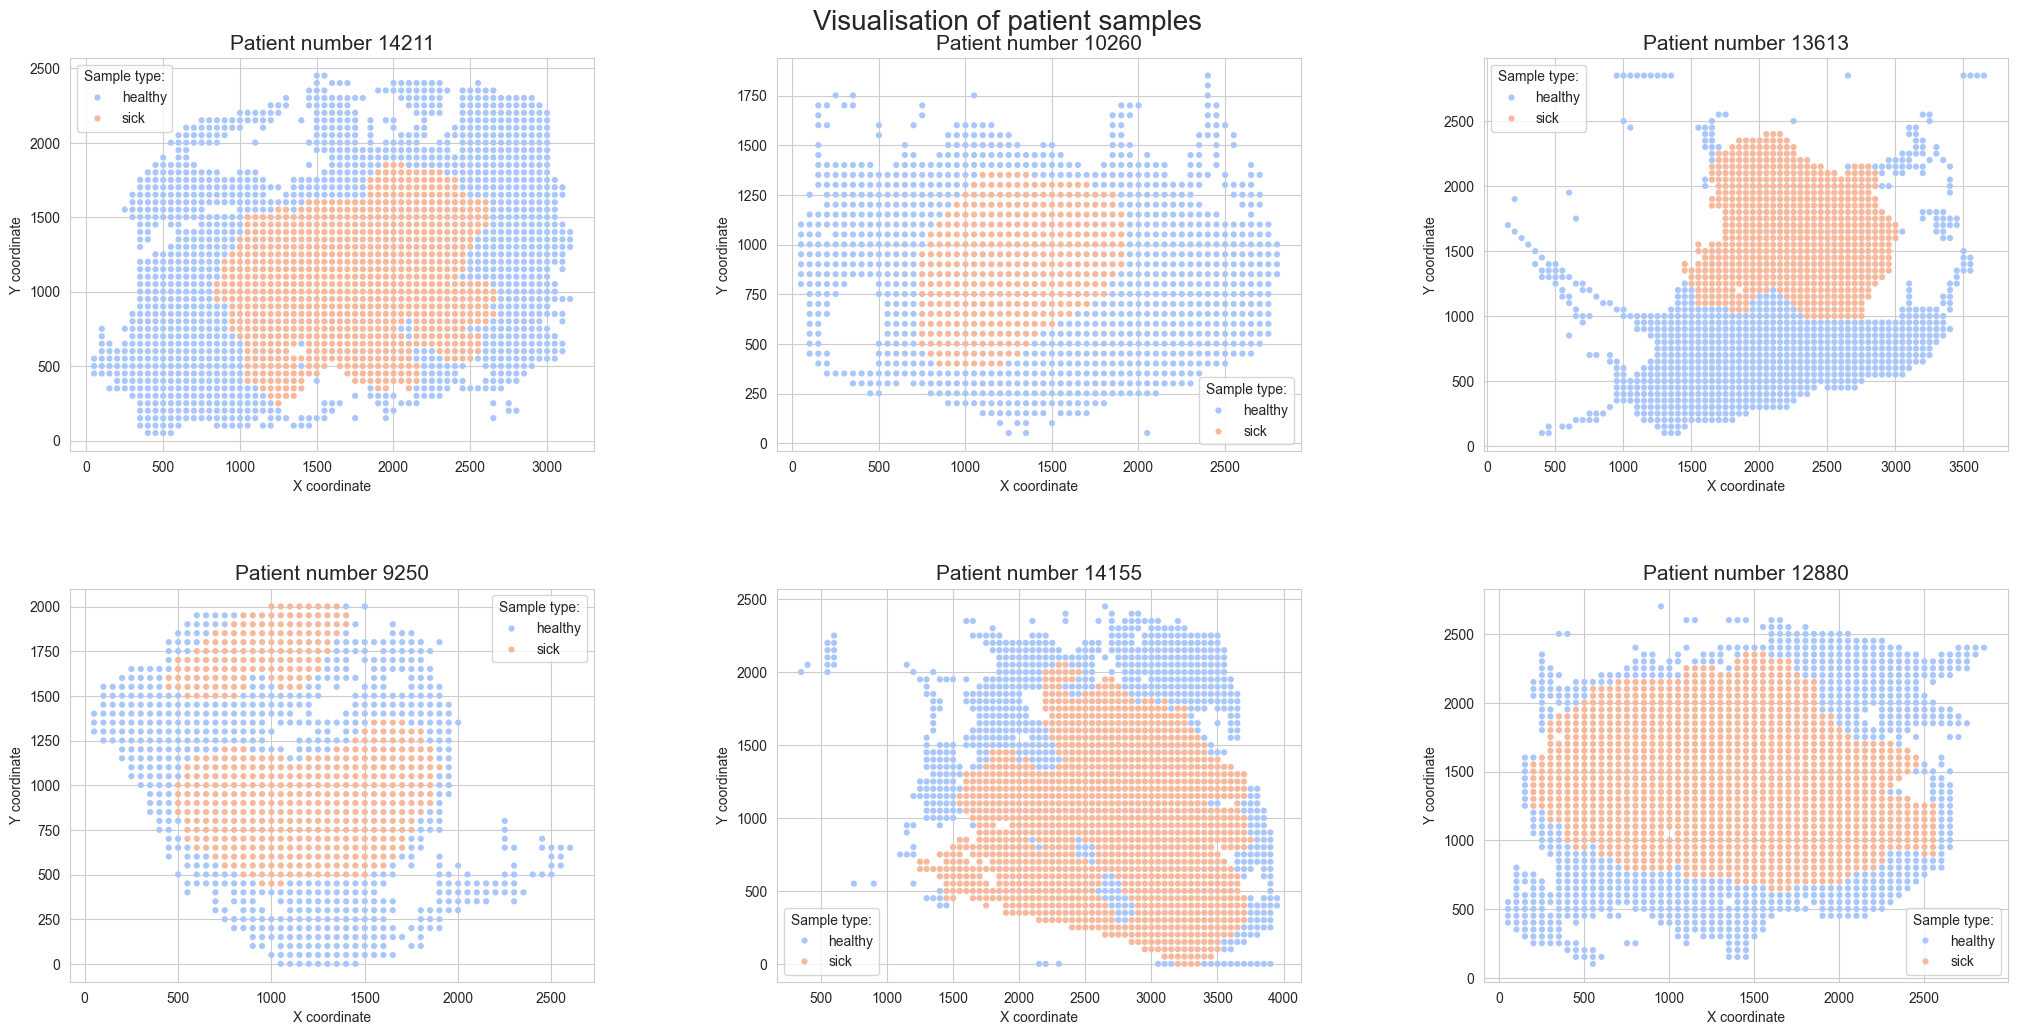

In [79]:
fig, ax = plt.subplots(2,3, figsize = (25,12))
plt.subplots_adjust(wspace = 0.35, hspace = 0.35)
fig.suptitle('Visualisation of patient samples', y = 0.92, fontsize = 20)
for x in range(2):
    for y in range(3):
        patient_id = random_patients[x + y * 2]
        patient_samples_visualisation(patient_id, x, y)

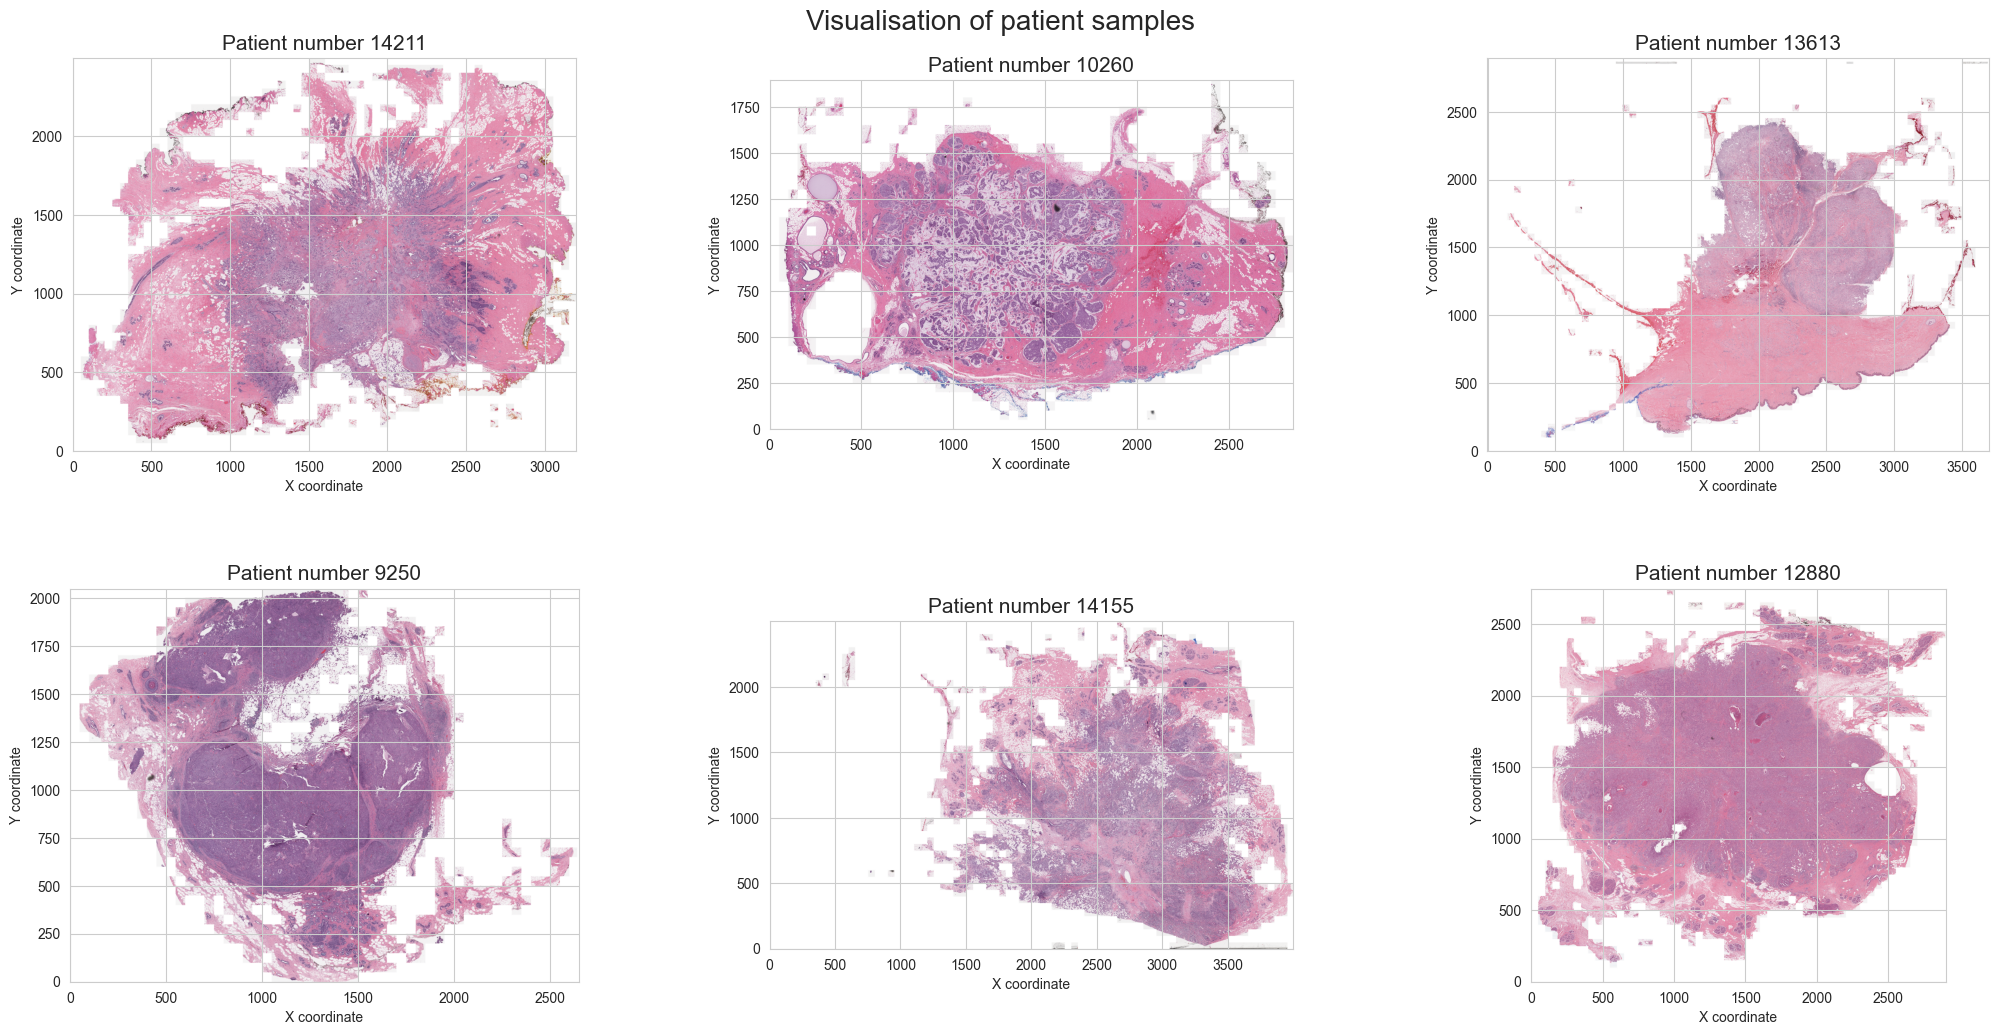

In [81]:
fig, ax = plt.subplots(2,3, figsize = (25,12))
plt.subplots_adjust(wspace = 0.35, hspace = 0.35)
fig.suptitle('Visualisation of patient samples', y = 0.92, fontsize = 20)
for x in range(2):
    for y in range(3):
        patient_id = random_patients[x + y * 2]
        tissue, ilness = patient_tissue_visualisation(patient_id)
        ax[x,y].set_title('Patient number ' + str(patient_id), fontsize = 15)
        ax[x,y].imshow(tissue, origin='lower', alpha = 0.9)
        ax[x,y].imshow(tissue, origin='lower', alpha = 0.7)
        ax[x,y].set_xlabel('X coordinate')
        ax[x,y].set_ylabel('Y coordinate')

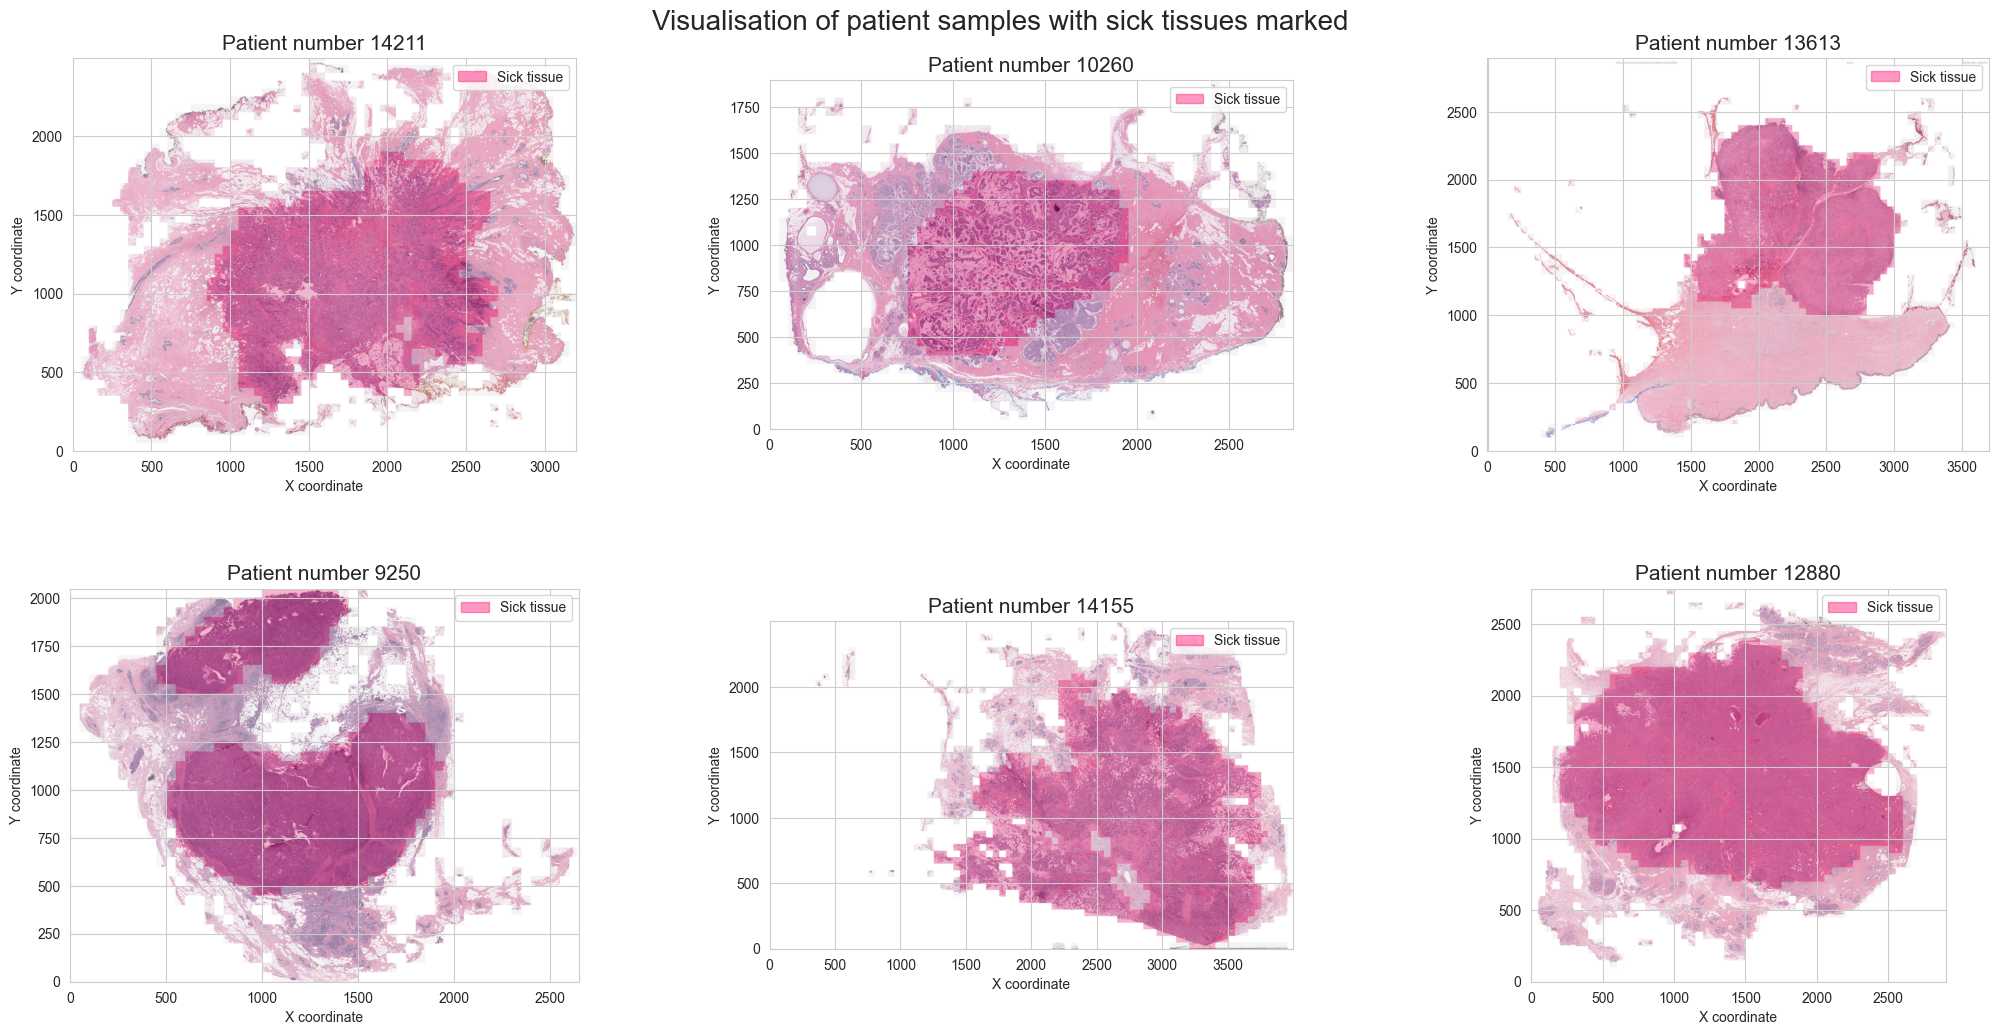

In [82]:
fig, ax = plt.subplots(2,3, figsize = (25,12))
plt.subplots_adjust(wspace = 0.35, hspace = 0.35)
fig.suptitle('Visualisation of patient samples with sick tissues marked', y = 0.92, fontsize = 20)
cancer_patch = mpatches.Patch(color= (1, 0, 0.4, 0.4), label='Sick tissue')
for x in range(2):
    for y in range(3):
        patient_id = random_patients[x + y * 2]
        tissue, ilness = patient_tissue_visualisation(patient_id)
        ax[x,y].set_title('Patient number ' + str(patient_id), fontsize = 15)
        ax[x,y].imshow(tissue, origin='lower', alpha = 0.9)
        ax[x,y].imshow(ilness, origin='lower', alpha = 0.8)
        ax[x,y].imshow(tissue, origin='lower', alpha = 0.7)
        ax[x,y].set_xlabel('X coordinate')
        ax[x,y].set_ylabel('Y coordinate')
        ax[x,y].legend(handles=[cancer_patch])

In [20]:
patients_df.head()

patient_id  label                                         image_path
0        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
1        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
2        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
3        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...
4        9036      0  /Users/bartoszlowicki/Desktop/DS/Projects/Brea...

In [21]:
patients_ids = patients_df.patient_id.unique()
print(patients_ids)

[ 9036 10268 10257  8913 13613  8914 15510 10259 16165 10292 12951 10261
 10295  9259 12750 13020 16552 12905  9266 16555 13018  9261  9257 12934
 12933  9250 10260 10258 10293  9037 10269 16531 10256 15516 12932 12935
  9256 16554  9260 13019 16553 13021  8984  9258 12751  9267 12876 12882
 15634 12871 14188 15633  9324 12878  9323  9383  8867  9346  9174 12822
  9173  9322  9325 12879 14189 12870 12884 12241 15632 12883 12877  9126
 13106 12823 13591  9175 12824  9347  9181  9382 10307 13916 10300 14306
 15471 16896 14156  9135 12890 12897 10308 10301 10306 12896 14157 12891
 12898 14192 13458  9083  9077 13460  8955 12910  9041 14210 14082 10274
  9227 10273 13402 14078  9023 12911 14211 13691  9078 12929 13461  9076
 13459 16570  9022 10288  9228 14079 10286 13403 10272 10275 13404  9226
 13024  8975 16569 12901  9262 13023 16551  9265 12906  9291 12930 13688
 12908  9254 16534  8917 15513 10253  9035 10254 15514 16533 13617 10262
 12955 16166 10291 12909  9255 14209 12931 13689 16

In [22]:
#patients_df["label"] = patients_df['label'].astype(str)

In [23]:
train_df, test_to_split = train_test_split(
    patients_df, test_size=0.4, random_state=100
)

In [24]:
test_set_df, valid_set_df = train_test_split(
    test_to_split, test_size=0.5, random_state=100
)

In [25]:
print(train_df.shape, test_set_df.shape, valid_set_df.shape)

(166514, 3) (55505, 3) (55505, 3)


In [26]:
print("Training set volume",len(train_df)/len(patients_df)*100,"%")
print("Validation set volume",len(valid_set_df)/len(patients_df)*100,"%")
print("Test set volume",len(test_set_df)/len(patients_df)*100,"%")

Training set volume 59.9998558683213 %
Validation set volume 20.00007206583935 %
Test set volume 20.00007206583935 %


In [27]:
training_dataframe = extracting_coordinates(train_df)
len(training_dataframe)

166514

In [28]:
validating_dataframe = extracting_coordinates(valid_set_df)
len(validating_dataframe)

55505

In [29]:
testing_dataframe = extracting_coordinates(test_set_df)
len(testing_dataframe)

55505

In [30]:
training_dataframe.dtypes

patient_id     int64
x              int64
y              int64
label          int64
image_path    object
dtype: object

[Text(0, 0, 'Healthy'), Text(1, 0, 'Sick')]

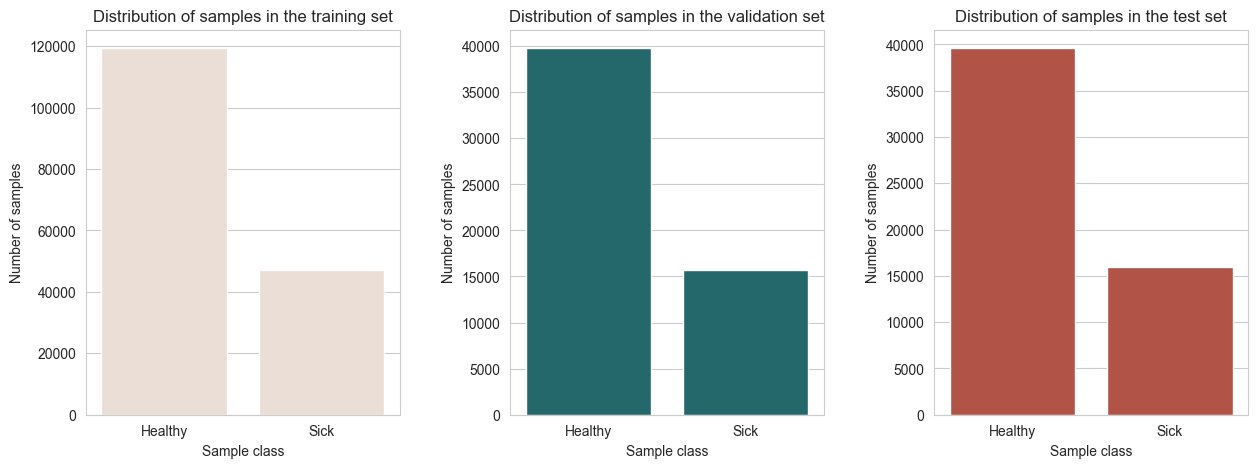

In [31]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
plt.subplots_adjust(wspace = 0.35)
sns.countplot(x = training_dataframe['label'].map({0:"healthy", 1:"sick"}), order=["healthy","sick"], color = (0.929, 0.867, 0.831), ax=ax[0])

ax[0].set_title("Distribution of samples in the training set")
ax[0].set_xlabel('Sample class')
ax[0].set_ylabel('Number of samples')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Healthy", "Sick"])

sns.countplot(x = validating_dataframe['label'].map({0:"healthy", 1:"sick"}), order=["healthy","sick"], color = (0.098, 0.447, 0.471), ax=ax[1])
ax[1].set_title("Distribution of samples in the validation set")
ax[1].set_xlabel('Sample class')
ax[1].set_ylabel('Number of samples')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Healthy", "Sick"])

sns.countplot(x = testing_dataframe['label'].map({0:"healthy", 1:"sick"}), order=["healthy","sick"], color = (0.769, 0.271, 0.212), ax=ax[2])
ax[2].set_title("Distribution of samples in the test set")
ax[2].set_xlabel('Sample class')
ax[2].set_ylabel('Number of samples')
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(["Healthy", "Sick"])

In [32]:
class BreastDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        patient_id = self.dataframe.patient_id.values[index]
        label = self.dataframe.label.values[index]
        label = np.asarray(label)
        class_name = torch.from_numpy(label.astype('long'))

        image_path = self.dataframe.image_path.values[index]
        image = Image.open(Path(image_path)).convert("RGB")

        if self.transform:
          image = self.transform(image)

        return {
            "label": class_name,
            "image": image,
            "patient_id": patient_id
        }

In [33]:
def data_transformation(data_type, plot = False):
    train = [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()]
    
    validation = [
        transforms.Resize((224, 224))]
    
    if not plot:
        extra = [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
            ]
        train.extend(extra)
        validation.extend(extra)
        
    transformation = {
        'training': transforms.Compose(train),
        'validation': transforms.Compose(validation)}
    
    return transformation[data_type]

In [34]:
train_dataset = BreastDataset(
    dataframe=train_df, transform=data_transformation(data_type="training")
)
valid_dataset = BreastDataset(
    dataframe=valid_set_df, transform=data_transformation(data_type="validation")
)
test_dataset = BreastDataset(
    dataframe=test_set_df, transform=data_transformation(data_type="validation")
)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

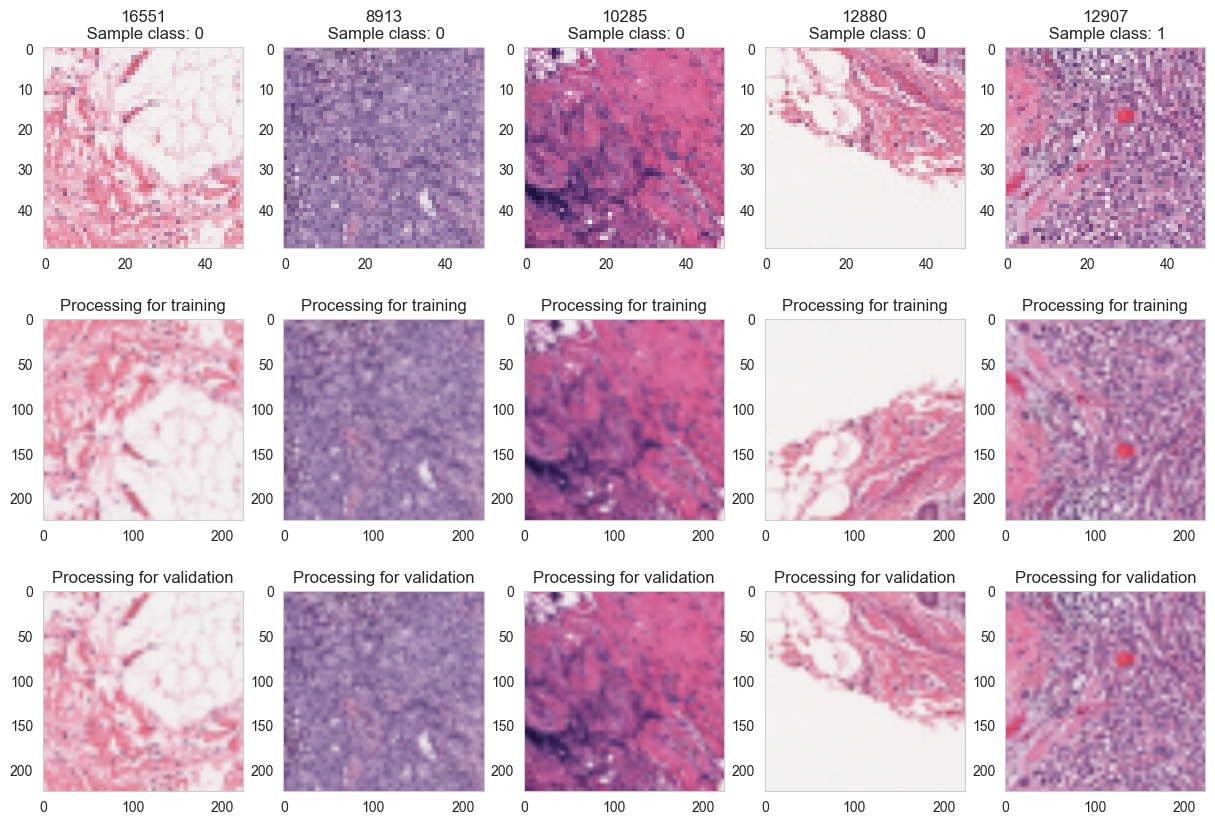

In [35]:
fig, ax = plt.subplots(3,5,figsize=(15,10))

train_transform = data_transformation(data_type="training", plot=True)
val_transform = data_transformation(data_type="validation", plot=True)

for i in range(5):
    filepath = training_dataframe.image_path.values[i]
    image = Image.open(filepath)
    ax[0,i].imshow(image)
    transformed_img = train_transform(image)
    ax[1,i].imshow(transformed_img)
    ax[2,i].imshow(val_transform(image))
    ax[0,i].grid(False)
    ax[1,i].grid(False)
    ax[2,i].grid(False)
    ax[0,i].set_title(str(training_dataframe.patient_id.values[i]) + '\n Sample class: '+ str(training_dataframe.label.values[i]))
    ax[1,i].set_title("Processing for training")
    ax[2,i].set_title("Processing for validation")

In [36]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

In [37]:
device = torch.device("mps")

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

should_load = (not FORCE_TRAIN) and os.path.exists(PATH_TO_LEARNED_MODEL)

if should_load:
    print(f"Saved model found: {PATH_TO_LEARNED_MODEL}")
    state_dict = torch.load(PATH_TO_LEARNED_MODEL, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model training skipped")

else:
    if FORCE_TRAIN and os.path.exists(PATH_TO_LEARNED_MODEL):
        print("FORCE_TRAIN=True — retraining despite an existing saved model")
    else:
        print("No saved model found — starting training")

    n_epochs = 2000
    valid_loss_min = np.inf
    epochs_no_improve = 0

    val_loss, val_acc = [], []
    train_loss, train_acc = [], []

    total_step = len(train_loader)

    for epoch in range(1, n_epochs + 1):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0
        print(f"Epoch {epoch}\n")

        for batch_idx, image in enumerate(train_loader):
            data_ = image["image"].to(device)
            target_ = image["label"].to(device).long()

            optimizer.zero_grad()
            outputs = model(data_)
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred == target_).item()
            total += target_.size(0)

            if batch_idx % 10 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch, n_epochs, batch_idx, total_step, loss.item()
                    )
                )

        train_acc.append(100 * correct / total)
        train_loss.append(running_loss / total_step)
        print(f"\ntrain-loss: {train_loss[-1]:.4f}, train-acc: {train_acc[-1]:.4f}")

        model.eval()
        batch_loss = 0.0
        total_t = 0
        correct_t = 0

        with torch.no_grad():
            for image in valid_loader:
                data_t = image["image"].to(device)
                target_t = image["label"].to(device).long()

                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t)

                batch_loss += loss_t.item()
                _, pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t == target_t).item()
                total_t += target_t.size(0)

        avg_val_loss = batch_loss / len(valid_loader)
        avg_val_acc = 100 * correct_t / total_t

        val_loss.append(avg_val_loss)
        val_acc.append(avg_val_acc)

        print(f"validation loss: {avg_val_loss:.4f}, validation acc: {avg_val_acc:.4f}\n")

        if batch_loss < valid_loss_min:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), PATH_TO_LEARNED_MODEL)
            print("Improvement-Detected, SAVED MODEL ✅")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == 20:
                print("Early stopping!")
                break

    fig = plt.figure(figsize=(20, 10))
    plt.title("Train-Validation Accuracy")
    plt.plot(train_acc, label="train")
    plt.plot(val_acc, label="validation")
    plt.xlabel("num_epochs", fontsize=12)
    plt.ylabel("accuracy", fontsize=12)
    plt.legend(loc="best")
    plt.show()


Saved model found: /Users/bartoszlowicki/Desktop/DS/Projects/Breast Histopathology Images/data/notebooks/models/best_model_resnet.pt
Model training skipped


In [38]:
device = torch.device("mps")
model.eval()
model.to(device)

y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing model:"):
        x = batch["image"].to(device)
        y = batch["label"].to(device)

        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())


Testing model::   0%|          | 0/1735 [00:00<?, ?it/s]

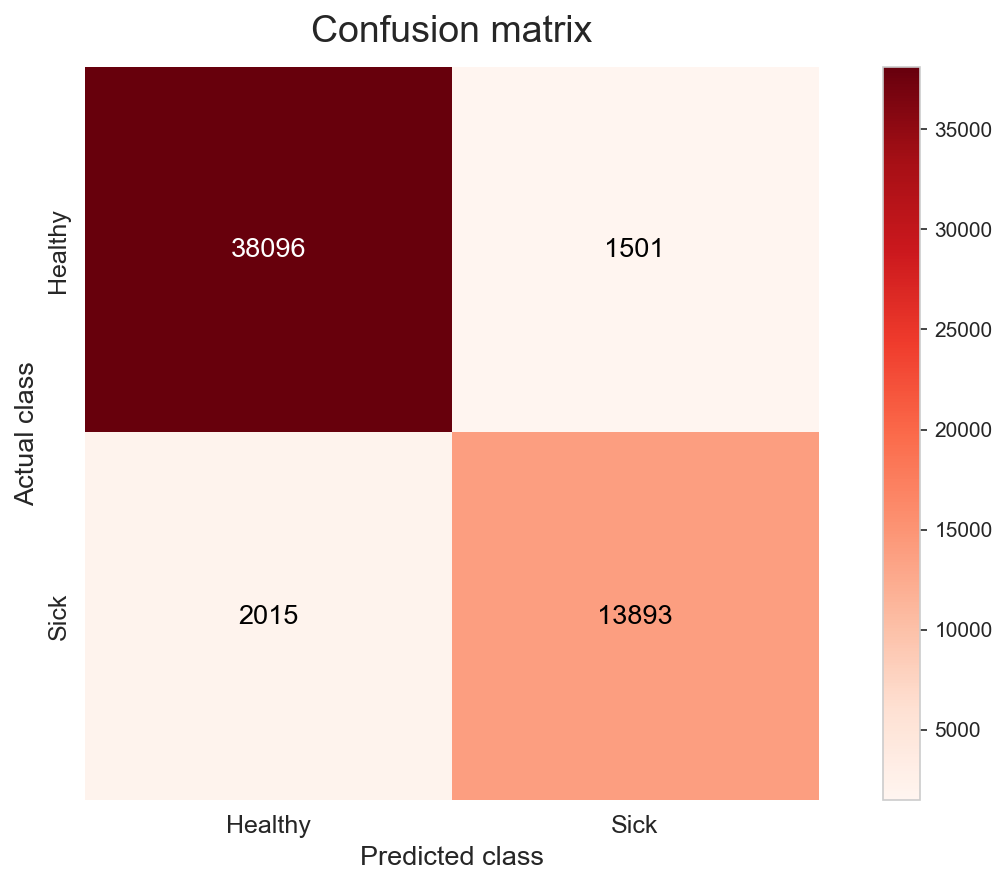

In [39]:
cm = confusion_matrix(y_true, y_pred)
labels = ["Healthy", "Sick"]
fig, ax = plt.subplots(figsize=(9, 6), dpi=150)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Reds", values_format="d", colorbar=True)

ax.set_title("Confusion matrix", fontsize=18, pad=12)
ax.set_xlabel("Predicted class", fontsize=13)
ax.set_ylabel("Actual class", fontsize=13)

ax.set_xticklabels(labels, fontsize=12, rotation=0)
ax.set_yticklabels(labels, fontsize=12, rotation=90, va="center")

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)

thresh = cm.max() / 2
for txt in disp.text_.ravel():
    val = int(txt.get_text())
    txt.set_fontsize(13)
    txt.set_color("white" if val > thresh else "black")

plt.tight_layout()
plt.show()
